In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0,'..')

In [3]:
from src.datamodules.emotic_datamodule import EmoticDataModule

In [4]:
datamodule = EmoticDataModule("../data")

In [5]:
datamodule.prepare_data()

['configs', 'bash', 'data', 'val_thresholds.npy', 'pretrained_weights', '.git', 'setup.cfg', 'sample_inference_list.txt', 'requirements.txt', 'README.md', 'tests', 'LICENSE', 'run.py', 'src', '.gitignore', 'notebooks']
Emotic_pre files are already exist Skipping


In [6]:
datamodule.setup()

train  context  (15918, 224, 224, 3) body (15918, 128, 128, 3) cat  (15918, 26) cont (15918, 3)
val  context  (2378, 224, 224, 3) body (2378, 128, 128, 3) cat  (2378, 26) cont (2378, 3)
test  context  (5292, 224, 224, 3) body (5292, 128, 128, 3) cat  (5292, 26) cont (5292, 3)


In [7]:
train_dataloader = iter(datamodule.train_dataloader())

In [8]:
batch = next(train_dataloader)  # img, img_info, (hard labels, polarities), text encodings

In [9]:
print(batch)

[tensor([[[[ 2.1117,  2.1117,  2.1117,  ...,  0.9419,  0.9731,  1.0199],
          [ 2.1117,  2.1117,  2.1117,  ...,  0.8639,  0.9263,  1.1135],
          [ 2.1117,  2.1117,  2.1117,  ...,  0.6456,  0.8171,  0.5208],
          ...,
          [ 2.1117,  2.1117,  2.1117,  ...,  2.1117,  2.1117,  2.1117],
          [ 2.1117,  2.1117,  2.1117,  ...,  2.1117,  2.1117,  2.1117],
          [ 2.1117,  2.1117,  2.1117,  ...,  2.1117,  2.1117,  2.1117]],

         [[ 2.3003,  2.3003,  2.3003,  ..., -0.5707, -0.4256, -0.3610],
          [ 2.3003,  2.3003,  2.3003,  ..., -0.4901, -0.5546, -0.4740],
          [ 2.3003,  2.3003,  2.3003,  ..., -0.2965, -0.2965, -0.6675],
          ...,
          [ 1.3971,  1.4616,  1.5745,  ...,  1.4939,  1.4455,  1.4616],
          [ 1.3971,  1.3809,  1.3648,  ...,  1.4293,  1.4616,  1.5422],
          [ 1.4777,  1.6229,  1.6713,  ...,  1.4616,  1.3648,  1.5745]],

         [[ 2.4515,  2.4515,  2.4515,  ..., -0.5866, -0.4250, -0.6027],
          [ 2.4515,  2.4515, 

In [10]:
batch[0].shape  # Image

torch.Size([64, 3, 224, 224])

In [11]:
batch[1].shape  # Body

torch.Size([64, 3, 128, 128])

In [12]:
batch[2].shape   # 26 Emotion Class

torch.Size([64, 26])

In [13]:
batch[3].shape    # Valence, Arousal, Dominance (Check the ordering)

torch.Size([64, 3])

In [14]:
from src.models.emotic_baseline_model import EmoticBaselineModel

In [15]:
model = EmoticBaselineModel(26,3,"../pretrained_weights")

In [16]:
out = model(batch)

In [17]:
out[0].shape # Batch Size 26 emotion class predictions 

torch.Size([64, 26])

In [18]:
out[1].shape  # Batch Size 3 emotion continious class predictions 

torch.Size([64, 3])

# INFERENCE
By using pretrained models inference on the new images

In [19]:
import torch
import numpy as np
from src.models.modules.emotic_baseline import Emotic

In [20]:
inference_list = '../sample_inference_list.txt'

"""
# THE LIST contains image path and bounding boxes x1 y1 x2 y2 format

sample_inference_list.txt

data/emotic/mscoco/images/COCO_val2014_000000562243.jpg 86 58 564 628
data/emotic/mscoco/images/COCO_train2014_000000288841.jpg 485 149 605 473
data/emoreccon_subset_train/0_35_3.jpg 10 168 325 554
data/emoreccon_subset_train/4_3_0.jpg 47 253 410 602
data/emoreccon_subset_train/21_44_0.jpg 0 85 317 95
data/emoreccon_subset_train/21_44_0.jpg 291 195 533 497
data/emoreccon_subset_train/18_9_4.jpg 157 205 431 560

"""

'\n# THE LIST contains image path and bounding boxes x1 y1 x2 y2 format\n\nsample_inference_list.txt\n\ndata/emotic/mscoco/images/COCO_val2014_000000562243.jpg 86 58 564 628\ndata/emotic/mscoco/images/COCO_train2014_000000288841.jpg 485 149 605 473\ndata/emoreccon_subset_train/0_35_3.jpg 10 168 325 554\ndata/emoreccon_subset_train/4_3_0.jpg 47 253 410 602\ndata/emoreccon_subset_train/21_44_0.jpg 0 85 317 95\ndata/emoreccon_subset_train/21_44_0.jpg 291 195 533 497\ndata/emoreccon_subset_train/18_9_4.jpg 157 205 431 560\n\n'

In [21]:
with open(inference_list, 'r') as f:
    lines = f.readlines()

In [22]:
device = torch.device("cuda:0" 
                      if torch.cuda.is_available() else "cpu")

In [23]:
model_path = "../pretrained_weights/models"

In [24]:
# PRETRAINED WEIGHTS FOR INFERENCE

thresholds = torch.FloatTensor(np.load(os.path.join("..", 'val_thresholds.npy'))).to(device) 
model_context = torch.load(os.path.join(model_path,'model_context1.pth')).to(device)
model_body = torch.load(os.path.join(model_path,'model_body1.pth')).to(device)
emotic_model = torch.load(os.path.join(model_path,'model_emotic1.pth')).to(device)
model_context.eval()
model_body.eval()
emotic_model.eval()
models = [model_context, model_body, emotic_model]

In [44]:
import cv2
import numpy as np 
import os 

import torch 
from torchvision import transforms
from PIL import Image
def process_images(context_norm, body_norm, image_context_path=None,
                   image_context=None, image_body=None, bbox=None):
    
    '''
    :param context_norm: List containing mean and std values for context images. 
    :param body_norm: List containing mean and std values for body images. 
    :param image_context_path: Path of the context image. 
    :param image_context: Numpy array of the context image.
    :param image_body: Numpy array of the body image. 
    :param bbox: List to specify the bounding box to generate the body image. bbox = [x1, y1, x2, y2].
    :return: Transformed image_context tensor and image_body tensor.

    '''
    if image_context is None and image_context_path is None:
        raise ValueError('both image_context and image_context_path cannot be none. Please specify one of the two.')

    if image_body is None and bbox is None: 
        raise ValueError('both body image and bounding box cannot be none. Please specify one of the two')

    if image_context_path is not None:
        image_context =  cv2.cvtColor(cv2.imread(image_context_path), cv2.COLOR_BGR2RGB)
      
    #EXTRACT Bounding Box
    if bbox is not None:
        image_body = image_context[bbox[1]:bbox[3],bbox[0]:bbox[2]].copy()
  
    image_context = cv2.resize(image_context, (224,224))
    image_body = cv2.resize(image_body, (128,128))

    test_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
    context_norm = transforms.Normalize(context_norm[0], context_norm[1])  
    body_norm = transforms.Normalize(body_norm[0], body_norm[1])

    image_context = context_norm(test_transform(image_context)).unsqueeze(0)
    image_body = body_norm(test_transform(image_body)).unsqueeze(0)

    return image_context, image_body  


def infer(context_norm, body_norm, ind2cat, ind2vad, device, thresholds, models, image_context_path=None, image_context=None, image_body=None, bbox=None, to_print=True):
    ''' Perform inference over an image. 
    :param context_norm: List containing mean and std values for context images. 
    :param body_norm: List containing mean and std values for body images. 
    :param ind2cat: Dictionary converting integer index to categorical emotion. 
    :param ind2vad: Dictionary converting integer index to continuous emotion dimension (Valence, Arousal and Dominance).
    :param device: Torch device. Used to send tensors to GPU if available.
    :param image_context_path: Path of the context image. 
    :param image_context: Numpy array of the context image.
    :param image_body: Numpy array of the body image. 
    :param bbox: List to specify the bounding box to generate the body image. bbox = [x1, y1, x2, y2].
    :param to_print: Variable to display inference results.
    :return: Categorical Emotions list and continuous emotion dimensions numpy array.
    '''
    image_context, image_body = process_images(context_norm, body_norm, image_context_path=image_context_path, image_context=image_context, image_body=image_body, bbox=bbox)

    # Emotic models is fusion network
    # Context looks whole panel
    # Body is for bounding box
    model_context, model_body, emotic_model = models

    with torch.no_grad():
        image_context = image_context.to(device)
        image_body = image_body.to(device)

        pred_context = model_context(image_context)
        pred_body = model_body(image_body)
        pred_cat, pred_cont = emotic_model(pred_context, pred_body)
        pred_cat = pred_cat.squeeze(0)
        pred_cont = pred_cont.squeeze(0).to("cpu").data.numpy()

        bool_cat_pred = torch.gt(pred_cat, thresholds)

        cat_emotions = list()
        for i in range(len(bool_cat_pred)):
            if bool_cat_pred[i] == True:
                cat_emotions.append(ind2cat[i])

        if to_print == True:
            print ('\n Image predictions')
            print ('Continuous Dimnesions Predictions') 
            for i in range(len(pred_cont)):
                print ('Continuous %10s %.5f' %(ind2vad[i], 10*pred_cont[i]))
            print ('Categorical Emotion Predictions')
            for emotion in cat_emotions:
                print ('Categorical %16s' %(emotion))

        return cat_emotions, 10*pred_cont

In [45]:
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection', \
            'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear','Happiness', \
            'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']
cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
    cat2ind[emotion] = idx
    ind2cat[idx] = emotion

vad = ['Valence', 'Arousal', 'Dominance']
ind2vad = {}
for idx, continuous in enumerate(vad):
    ind2vad[idx] = continuous

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

In [46]:
for idx, line in enumerate(lines):
    image_context_path, x1, y1, x2, y2 = line.split('\n')[0].split(' ')
    bbox = [int(x1), int(y1), int(x2), int(y2)]
    print(bbox)
    print(os.path.join('..',image_context_path))
    image_context_path = os.path.join('..',image_context_path)
    pred_cat, pred_cont = infer(context_norm, body_norm, ind2cat, ind2vad, device, thresholds,
                                models, image_context_path=image_context_path, bbox=bbox)
    print('\n')

[86, 58, 564, 628]
../data/emotic/mscoco/images/COCO_val2014_000000562243.jpg

 Image predictions
Continuous Dimnesions Predictions
Continuous    Valence 4.21654
Continuous    Arousal 4.80335
Continuous  Dominance 5.51875
Categorical Emotion Predictions
Categorical            Anger
Categorical        Annoyance
Categorical         Aversion
Categorical       Confidence
Categorical      Disapproval
Categorical     Disquietment
Categorical  Doubt/Confusion
Categorical          Fatigue
Categorical             Fear
Categorical             Pain
Categorical          Sadness
Categorical        Suffering
Categorical         Surprise


[485, 149, 605, 473]
../data/emotic/mscoco/images/COCO_train2014_000000288841.jpg

 Image predictions
Continuous Dimnesions Predictions
Continuous    Valence 6.15573
Continuous    Arousal 5.12500
Continuous  Dominance 6.61870
Categorical Emotion Predictions
Categorical       Engagement
Categorical        Happiness


[10, 168, 325, 554]
../data/emoreccon_subset_trai

# SINGLE IMAGE INFERENCE


 Image predictions
Continuous Dimnesions Predictions
Continuous    Valence 6.43685
Continuous    Arousal 4.88141
Continuous  Dominance 6.81913
Categorical Emotion Predictions
Categorical       Confidence
Categorical       Excitement
Categorical        Happiness
Categorical         Pleasure


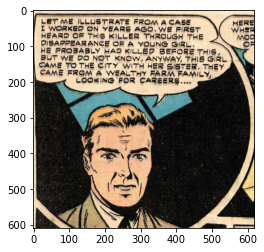

In [47]:
img_path = "../data/emoreccon_subset_train/4_3_0.jpg"
bbox = [47, 253, 410, 602]
plt.imshow(Image.open(img_path))
pred_cat, pred_cont = infer(context_norm, body_norm, ind2cat, ind2vad, device, thresholds,
                                models, image_context_path=img_path, bbox=bbox)